Here is an attempt to use a neural network to make FFC material hardship predictions.

1. [Imports](#ims)
2. [Data preprocessing](#pp)  

# 1. Imports<a name="ims"></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
np.random.seed(1234)
print('reading in csv files')
# File read in
# See documentation for more descriptions
# http://www.fragilefamilieschallenge.org/apply/
background = pd.read_csv('background.csv', low_memory=False)
print('read background.csv')
train = pd.read_csv('train.csv', low_memory=False)
print('read train.csv')
prediction = pd.read_csv('prediction.csv', low_memory=False)
print('read prediction.csv')
print("Files read")

reading in csv files
read background.csv
read train.csv
read prediction.csv
Files read


In [3]:
y_train_materialHardship = train[['challengeID', 'materialHardship']]

In [29]:
y_train_materialHardship = y_train_materialHardship.dropna() # drop nas
  

# Create train df with rows in y_train
# Subset background df to do so.
df_train_mh = background.loc[background['challengeID'].isin(y_train_materialHardship['challengeID'])]

# Create a test dataframe too. This df contains
# individuals who are NOT in the training set.
# We will need to make predictions on these.
df_test_mh = background.loc[~background['challengeID'].isin(y_train_materialHardship['challengeID'])]

In [5]:
df_train_mh.head()

,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
5,6,-3,NaN,0,25,NaN,1,NaN,NaN,NaN,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3,-3.000000,10.255825
6,7,-3,NaN,0,35,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3,10.972726,10.859800
8,9,-3,NaN,0,30,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3,9.842380,9.566678
9,10,-3,NaN,0,33,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3,-3.000000,10.105870
12,13,-3,NaN,1,-3,NaN,1,NaN,NaN,NaN,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3,-3.000000,9.566678


Check out what kinds of data we have:

In [6]:
# distribution of different data types
df_train_mh.dtypes.value_counts()

int64      9489
float64    3307
object      147
dtype: int64

# 2. Data Preprocessing<a name="pp"></a>

The data is **imbalanced**. 

In [7]:
y_train_materialHardship['materialHardship'].value_counts().reset_index()

,index,materialHardship
0,0.000000,807
1,0.090909,248
2,0.181818,136
3,0.272727,104
4,0.363636,61
5,0.454545,58
6,0.545455,26
7,0.636364,11
8,0.727273,6
9,0.818182,2


/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


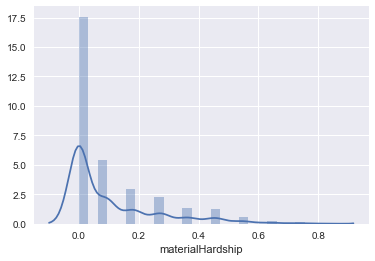

In [8]:
sns.distplot(y_train_materialHardship['materialHardship'])
plt.show()

Most of the {{len(y_train_materialHardship)}} individuals do not experience material hardship. See this [link](http://www.fragilefamilieschallenge.org/material-hardship/) for documentation on this variable. 

In [9]:
np.dtype(y_train_materialHardship['materialHardship'])

dtype('float64')

Though np recognizes this variable as a float, it is really categorical, with an individual having anywhere from 0 to all 11 material hardship conditions experienced in the affirmative.

I am not sure, but I think it might be better to convert this to categorical to predict with a neural network (or with a decision tree). It seems like converting to one of 11 categories would make the problem simpler -- instead of trying to predict a continuous range from [0,1], we only need to predict one of 11 categories. It is probably easier to make a bet on 1/11 categories, instead of 1/$\infty$ categories!

In [10]:
a = y_train_materialHardship['materialHardship']*11
b = round(a)
b.value_counts()

0.0    807
1.0    248
2.0    136
3.0    104
4.0     61
5.0     58
6.0     26
7.0     11
8.0      6
9.0      2
Name: materialHardship, dtype: int64

In [11]:
y_train_materialHardship['materialHardship'] = b.astype(object)

In [12]:
import collections
collections.Counter(y_train_materialHardship['materialHardship'])

Counter({0.0: 807,
         1.0: 248,
         2.0: 136,
         3.0: 104,
         4.0: 61,
         5.0: 58,
         6.0: 26,
         7.0: 11,
         8.0: 6,
         9.0: 2})

In [13]:
np.dtype(y_train_materialHardship['materialHardship'])

dtype('O')

OK, so we converted to an object type with 10 categories (no one went 11 for 11 in the training). But this could be problematic...we need to account for possibility that someone could have all 11 in the test set, so note this later on. 

## Missing value imputation

There is a crap ton of features in this set. {{df_train_mh.shape[1]}} to be exact. Unfortunately, a lot are missing. The authors of the challenge discuss this [here](http://www.fragilefamilieschallenge.org/missing-data/).

We can do imputation to fix this. This just means replacing missing values with a good guess, like the mean or median or a regression predictor. I think we should look into doing this.

BUT, call me crazy, but I think we should add MORE features. Here is my thought: for features that have a lot of missing values (what constitutes a lot? I don't yet know), we make another column that is simply binary -- either the data exists or it doesn't for this individual and this feature. Simply answering certain questions might be somewhat predictive, so I would think we want a feature that indicates if the response was NA or not. Then, whether or not it was NA, we should have the "real" feature that contains the question response.

*This is complicated by the fact that missing values aren't coded with NA's here. Typically they have negative values, but different negative numbers mean differen things...so this will be hard to do.*

Let's see if we can do it.

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


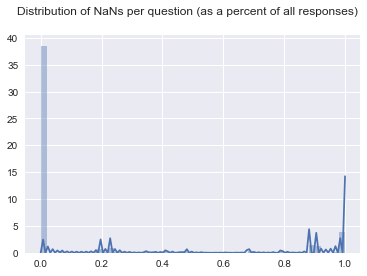

In [14]:
# distribution of NA per question...

# find % NA for each questoin
# make into list
# make histogram
import math
nan_percents = df_train_mh.isnull().sum() / len(df_train_mh)
sns.distplot(nan_percents)
sns.plt.suptitle('Distribution of NaNs per question (as a percent of all responses)')
plt.show()

In [15]:
num_all_na = sum(df_train_mh.isnull().sum()==len(df_train_mh))

Most questions have no NAN, but a bunch ({{num_all_na}}) have all NAN.

However, as I said before, a lot of the questions have coded responses, where negative responses are indicative of a missing response. 

In [16]:
df_train_mh_good_dtypes = df_train_mh.select_dtypes(include=(int, float))
num_ints_floats = df_train_mh_good_dtypes.shape[1]

There are {{num_ints_floats}} int or float variables out of {{df_train_mh.shape[1]}} total variables. So pretty much all variables have outputs that are numeric (even if these numbers are most often representitative of categories).

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


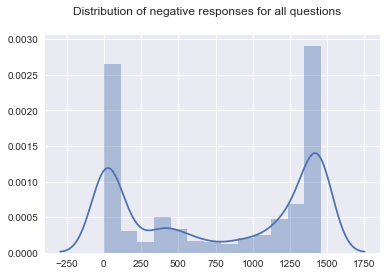

In [17]:
num_neg_vals = df_train_mh_good_dtypes.apply(lambda x: sum(x<0), axis=0)
sns.distplot(num_neg_vals)
sns.plt.suptitle('Distribution of negative responses for all questions')
plt.show()

Hmmm. The above histogram shows that most questions either have 0 negative values, or lots. All the way on the right, you can see that there are a lot of questions that have ~1500 negative values. Since there are {{len(df_train_mh)}} rows, I will assume that this right most bar just means ALL rows are negative in these columns. That is not helpful.

So, we want to deal with a) the absolute missing values (NAs) and with b) the coded missing values (negative numbers). 

### NA columns

1. If the entire column is NA, there is not much we can hope to do the way of imputation, so let's leave as is. 
2. For those columns where not all rows are NA, perhaps we can make a difference.

Which columns should we try to tackle, here? Let's just look at one column, first:

In [18]:
nans = nan_percents.reset_index(name='percent_NA')
nans.query('.01<percent_NA < .04')

,index,percent_NA
335,cm1finjail,0.011652
6900,cmf4fevjail,0.032899


Questions above have only a relatively few NAs. Can we use the sklearn imputer?

In [49]:
test_impute = df_train_mh[['cm1finjail','cmf4fevjail']]
test_impute.isnull().sum()

cm1finjail     17
cmf4fevjail    48
dtype: int64

In [53]:
from fancyimpute import SimpleFill
filled = SimpleFill('median').complete(test_impute)

In [51]:
filled = pd.DataFrame(filled)
filled.isnull().sum()
# so the SimpleFill works 

0    0
1    0
dtype: int64

What about using a more complicated filler?

In [72]:
from fancyimpute import MICE 
test_array = np.asarray(test_impute) # convert to np array
test_array.shape
mice_filled = MICE().complete(test_array) # complete the two columns in test_array
pd.DataFrame(mice_filled).isnull().sum() # this works too!

[MICE] Completing matrix with shape (1459, 2)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.002
[MICE] Starting imputation round 3/110, elapsed time 0.003
[MICE] Starting imputation round 4/110, elapsed time 0.004
[MICE] Starting imputation round 5/110, elapsed time 0.005
[MICE] Starting imputation round 6/110, elapsed time 0.006
[MICE] Starting imputation round 7/110, elapsed time 0.007
[MICE] Starting imputation round 8/110, elapsed time 0.008
[MICE] Starting imputation round 9/110, elapsed time 0.009
[MICE] Starting imputation round 10/110, elapsed time 0.010
[MICE] Starting imputation round 11/110, elapsed time 0.011
[MICE] Starting imputation round 12/110, elapsed time 0.012
[MICE] Starting imputation round 13/110, elapsed time 0.014
[MICE] Starting imputation round 14/110, elapsed time 0.015
[MICE] Starting imputation round 15/110, elapsed time 0.016
[MICE] Starting imputation round 16/110, elapsed time 0.017
[MI

0    0
1    0
dtype: int64

In [74]:
train_array = np.asarray(df_train_mh)
train_mice =  MICE().complete(train_array)

[MICE] Completing matrix with shape (1459, 12943)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Coded missing values

## Data augumentation and balancing

In image processing, if people have n pictures to train on, they will artificially increase the size of their training set by randomly altering a few pixels. They call this data [augmentation](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=data+augmentation+image+classification). This of course keeps the class of the image (eg cat) the same, but it gives the model a little bit extra of variation to learn from. This seems like it would work here, too. For example:

If Joe has a homeless mom who is single, and relatives visit 3x per week and Joe experiences 5/11 on material hardship, it seems reasonable to create another hypothetical individual who also has a homeless and single mom, whose relatives visit 2x a week and also experiences 5/11. If we feed both individuals to the model, it will hopefully learn better that the single and homeless mom is a strong predictor of material hardship, regardless of relative visitation.